In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customers/customer_dataset.csv


In [16]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader

In [3]:
# Load dataset
df = pd.read_csv("/kaggle/input/customers/customer_dataset.csv")


In [4]:
df.columns

Index(['CUSTOMER_ID', 'CONTACT_LAST_NAME', 'CONTACT_FIRST_NAME', 'STREET',
       'CITY', 'STATE', 'ZIP', 'COUNTRY', 'AGE', 'MARITAL_STATUS', 'GENDER',
       'NUMBER_OF_DEPENDENTS', 'GENERAL_SAVINGS_ASSETS',
       'HOME_OWNERSHIP_ASSETS', 'FAMILY_PLANNING_ASSETS', 'RETIREMENT_ASSETS',
       'UNKNOWN_ASSETS', 'TOTAL_ASSETS', 'Q1_ANSWER', 'Q2_ANSWER', 'Q3_ANSWER',
       'Q4_ANSWER', 'Q5_ANSWER', 'Q6_ANSWER', 'Q7_ANSWER', 'Q8_ANSWER',
       'AVG_ANSWER_SCORE', 'ENGAGEMENT_TYPE_ID', 'FREQUENCY_ID',
       'RISK_PROFILE'],
      dtype='object')

In [5]:
# Drop irrelevant columns
drop_cols = ['CUSTOMER_ID', 'CONTACT_LAST_NAME', 'CONTACT_FIRST_NAME', 'STREET', 'CITY', 'ZIP']  # update as needed
df_clean = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Encode categorical variables for correlation calculation
df_encoded = df_clean.copy()
for col in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


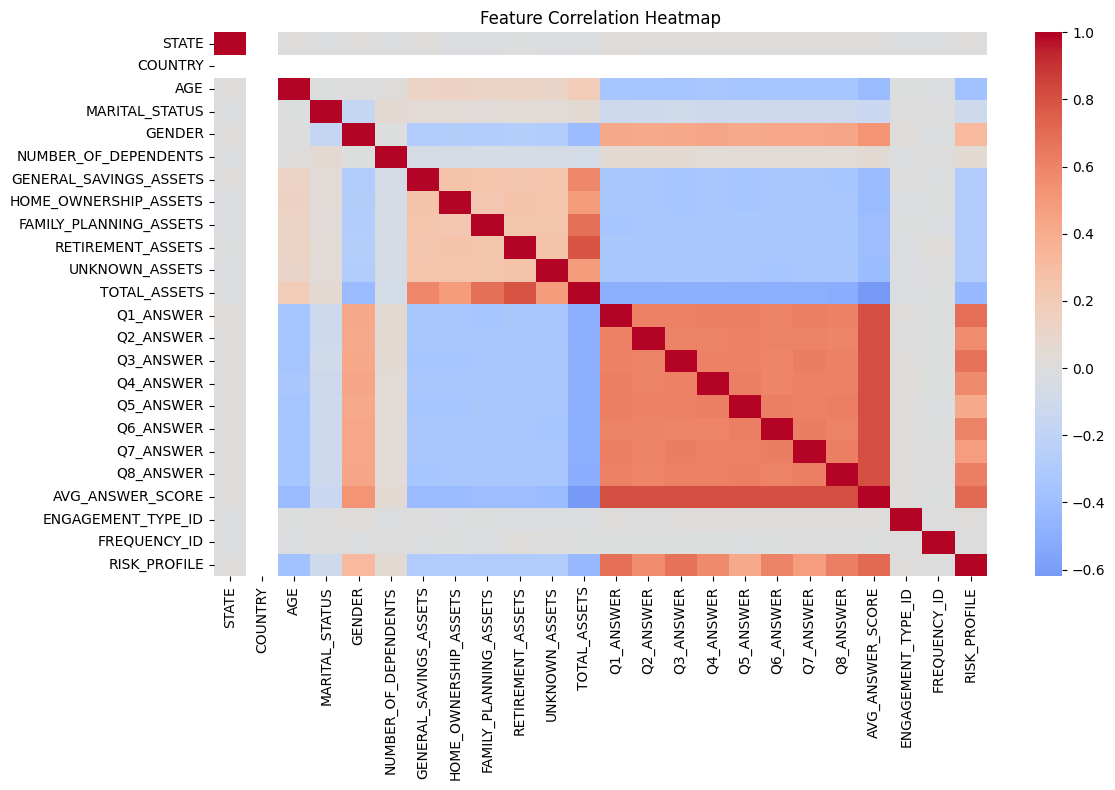

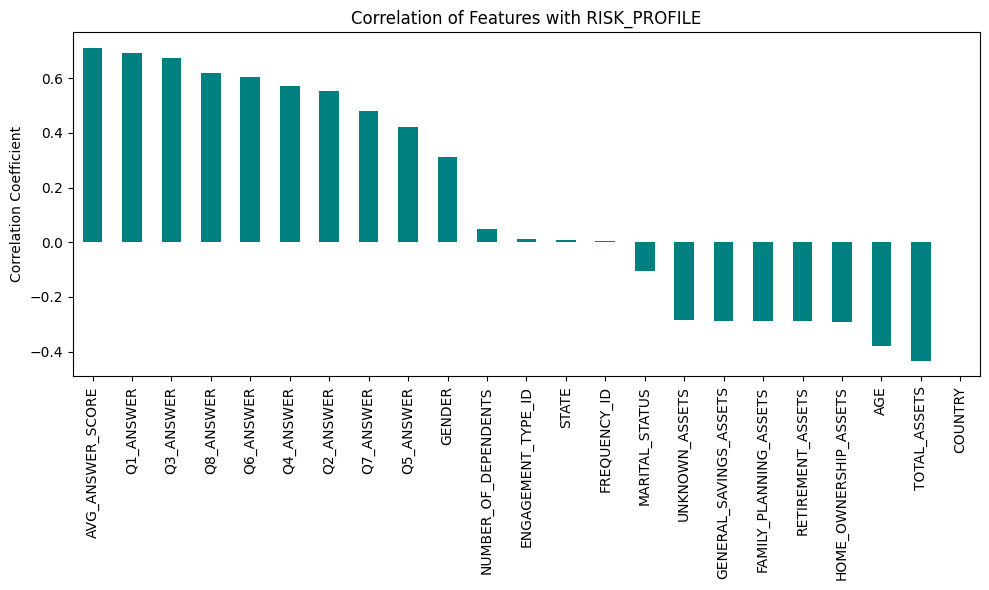

Correlation of Features with RISK_PROFILE:

RISK_PROFILE              1.000000
AVG_ANSWER_SCORE          0.710696
Q1_ANSWER                 0.690598
Q3_ANSWER                 0.675708
Q8_ANSWER                 0.620054
Q6_ANSWER                 0.606165
Q4_ANSWER                 0.569796
Q2_ANSWER                 0.552140
Q7_ANSWER                 0.480082
Q5_ANSWER                 0.420533
GENDER                    0.311157
NUMBER_OF_DEPENDENTS      0.048051
ENGAGEMENT_TYPE_ID        0.012740
STATE                     0.010074
FREQUENCY_ID              0.006149
MARITAL_STATUS           -0.103741
UNKNOWN_ASSETS           -0.282810
GENERAL_SAVINGS_ASSETS   -0.286817
FAMILY_PLANNING_ASSETS   -0.287517
RETIREMENT_ASSETS        -0.288464
HOME_OWNERSHIP_ASSETS    -0.291477
AGE                      -0.378282
TOTAL_ASSETS             -0.433412
COUNTRY                        NaN
Name: RISK_PROFILE, dtype: float64


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [6]:
corr_matrix = df_encoded.corr()

# Correlation with RISK_PROFILE
corr_with_target = corr_matrix['RISK_PROFILE'].sort_values(ascending=False)

# Plot full heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

# Plot bar chart of correlation with target
plt.figure(figsize=(10,6))
corr_with_target.drop("RISK_PROFILE").plot(kind="bar", color="teal")
plt.title("Correlation of Features with RISK_PROFILE")
plt.ylabel("Correlation Coefficient")
plt.tight_layout()
plt.show()

print("Correlation of Features with RISK_PROFILE:\n")
print(corr_with_target)


In [1]:
# ============================================
# CHUNK 1: IMPORTS AND DATA LOADING
# ============================================

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully!")

# Load dataset
df = pd.read_csv("/kaggle/input/customers/customer_dataset.csv")

print(f"\nDataset loaded: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# ============================================
# CHUNK 2: DATA PREPROCESSING
# ============================================

# Define columns to drop
drop_cols = [
    'CUSTOMER_ID', 'CONTACT_LAST_NAME', 'CONTACT_FIRST_NAME',
    'STREET', 'CITY', 'STATE', 'ZIP', 'COUNTRY'
]

# Clean dataframe
df_model = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Identify feature types
categorical_cols = df_model.select_dtypes(include=['object']).columns.tolist()
if 'RISK_PROFILE' in categorical_cols:
    categorical_cols.remove('RISK_PROFILE')

numerical_cols = df_model.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'RISK_PROFILE' in numerical_cols:
    numerical_cols.remove('RISK_PROFILE')

print(f"\nCategorical features ({len(categorical_cols)}): {categorical_cols}")
print(f"Numerical features ({len(numerical_cols)}): {numerical_cols}")

# Encode categorical variables
label_encoders = {}
df_encoded = df_model.copy()

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le

# Separate features and target
X = df_encoded.drop("RISK_PROFILE", axis=1)
y = df_encoded["RISK_PROFILE"] - 1  # Convert to 0-4 range

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.1, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"\nData split - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print("✓ Preprocessing complete!")

✓ Libraries imported successfully!

Dataset loaded: (10000, 30)
Columns: ['CUSTOMER_ID', 'CONTACT_LAST_NAME', 'CONTACT_FIRST_NAME', 'STREET', 'CITY', 'STATE', 'ZIP', 'COUNTRY', 'AGE', 'MARITAL_STATUS', 'GENDER', 'NUMBER_OF_DEPENDENTS', 'GENERAL_SAVINGS_ASSETS', 'HOME_OWNERSHIP_ASSETS', 'FAMILY_PLANNING_ASSETS', 'RETIREMENT_ASSETS', 'UNKNOWN_ASSETS', 'TOTAL_ASSETS', 'Q1_ANSWER', 'Q2_ANSWER', 'Q3_ANSWER', 'Q4_ANSWER', 'Q5_ANSWER', 'Q6_ANSWER', 'Q7_ANSWER', 'Q8_ANSWER', 'AVG_ANSWER_SCORE', 'ENGAGEMENT_TYPE_ID', 'FREQUENCY_ID', 'RISK_PROFILE']

Categorical features (2): ['MARITAL_STATUS', 'GENDER']
Numerical features (19): ['AGE', 'NUMBER_OF_DEPENDENTS', 'GENERAL_SAVINGS_ASSETS', 'HOME_OWNERSHIP_ASSETS', 'FAMILY_PLANNING_ASSETS', 'RETIREMENT_ASSETS', 'UNKNOWN_ASSETS', 'TOTAL_ASSETS', 'Q1_ANSWER', 'Q2_ANSWER', 'Q3_ANSWER', 'Q4_ANSWER', 'Q5_ANSWER', 'Q6_ANSWER', 'Q7_ANSWER', 'Q8_ANSWER', 'AVG_ANSWER_SCORE', 'ENGAGEMENT_TYPE_ID', 'FREQUENCY_ID']

Data split - Train: (9000, 21), Val: (500, 21)

In [2]:
# ============================================
# CHUNK 3: MODEL TRAINING
# ============================================

# Define optimized XGBoost
xgb_optimized = XGBClassifier(
    n_estimators=700,
    learning_rate=0.04138817087314107,
    max_depth=8,
    subsample=0.983166324530276,
    colsample_bytree=0.9157806346818161,
    reg_alpha=0.059808607526603386,
    reg_lambda=0.48121188334273113,
    objective="multi:softmax",
    num_class=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss"
)

# Define Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    random_state=42
)

# Create Stacking Classifier
stack_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_optimized),
        ('rf', rf)
    ],
    final_estimator=LogisticRegression(max_iter=200, multi_class="multinomial"),
    passthrough=True
)

print("Training stacking model... (this may take several minutes)")
stack_model.fit(X_train, y_train)
print("✓ Training complete!")

# ============================================
# CHUNK 4: MODEL EVALUATION
# ============================================

# Predictions
y_val_pred = stack_model.predict(X_val)
y_test_pred = stack_model.predict(X_test)

# Accuracies
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\nValidation Accuracy: {val_acc:.6f}")
print(f"Test Accuracy: {test_acc:.6f}")
print("\n" + "="*70)
print("CLASSIFICATION REPORT (Test Set)")
print("="*70)
print(classification_report(y_test, y_test_pred, digits=4))
print("\n" + "="*70)
print("CONFUSION MATRIX (Test Set)")
print("="*70)
print(confusion_matrix(y_test, y_test_pred))

Training stacking model... (this may take several minutes)
✓ Training complete!

Validation Accuracy: 0.898000
Test Accuracy: 0.896000

CLASSIFICATION REPORT (Test Set)
              precision    recall  f1-score   support

           0     1.0000    0.5000    0.6667         2
           1     0.9461    0.9518    0.9489       166
           2     0.8366    0.8421    0.8393       152
           3     0.8714    0.8777    0.8746       139
           4     1.0000    0.9512    0.9750        41

    accuracy                         0.8960       500
   macro avg     0.9308    0.8246    0.8609       500
weighted avg     0.8967    0.8960    0.8960       500


CONFUSION MATRIX (Test Set)
[[  1   1   0   0   0]
 [  0 158   8   0   0]
 [  0   8 128  16   0]
 [  0   0  17 122   0]
 [  0   0   0   2  39]]


In [3]:
# ============================================
# CHUNK 5: SAVE MODEL AND PREPROCESSING OBJECTS
# ============================================

import os

# Create directory
os.makedirs('risk_model', exist_ok=True)

# Save model
joblib.dump(stack_model, 'risk_model/model.pkl')
print("✓ Model saved")

# Save scaler
joblib.dump(scaler, 'risk_model/scaler.pkl')
print("✓ Scaler saved")

# Save label encoders
joblib.dump(label_encoders, 'risk_model/label_encoders.pkl')
print("✓ Label encoders saved")

# Save feature information
feature_info = {
    'feature_names': X.columns.tolist(),
    'categorical_features': categorical_cols,
    'numerical_features': numerical_cols,
    'target_mapping': {0: 1, 1: 2, 2: 3, 3: 4, 4: 5}  # Model output -> Actual Risk Profile
}
joblib.dump(feature_info, 'risk_model/feature_info.pkl')
print("✓ Feature info saved")

print("\n" + "="*70)
print("All files saved in 'risk_model/' folder:")
print("  1. model.pkl")
print("  2. scaler.pkl")
print("  3. label_encoders.pkl")
print("  4. feature_info.pkl")
print("="*70)
print("\nDownload these files and place them in your Flask app directory!")

✓ Model saved
✓ Scaler saved
✓ Label encoders saved
✓ Feature info saved

All files saved in 'risk_model/' folder:
  1. model.pkl
  2. scaler.pkl
  3. label_encoders.pkl
  4. feature_info.pkl

Download these files and place them in your Flask app directory!


In [4]:
# ============================================
# CHUNK 6: TEST PREDICTION PIPELINE
# ============================================

def predict_risk_profile(input_data, model, scaler, label_encoders, feature_info):
    """
    Predict risk profile for new customer data
    
    Parameters:
    -----------
    input_data : dict
        Dictionary with feature names as keys
    model : trained model
    scaler : fitted StandardScaler
    label_encoders : dict of LabelEncoders
    feature_info : dict with feature names and mappings
    
    Returns:
    --------
    dict : {
        'risk_profile': int (1-5),
        'confidence': float,
        'probabilities': dict
    }
    """
    import pandas as pd
    
    # Create dataframe
    input_df = pd.DataFrame([input_data])
    
    # Encode categorical features
    for col in feature_info['categorical_features']:
        if col in input_df.columns:
            try:
                input_df[col] = label_encoders[col].transform(input_df[col].astype(str))
            except ValueError:
                # Unknown category - use 0
                input_df[col] = 0
    
    # Ensure correct column order
    input_df = input_df[feature_info['feature_names']]
    
    # Scale
    input_scaled = scaler.transform(input_df)
    
    # Predict
    prediction = model.predict(input_scaled)[0]
    prediction_proba = model.predict_proba(input_scaled)[0]
    
    # Map to original scale (1-5)
    risk_profile = feature_info['target_mapping'][prediction]
    
    return {
        'risk_profile': int(risk_profile),
        'confidence': float(prediction_proba[prediction]),
        'probabilities': {
            f'Risk_{i+1}': float(prob) 
            for i, prob in enumerate(prediction_proba)
        }
    }

# Load saved models
loaded_model = joblib.load('risk_model/model.pkl')
loaded_scaler = joblib.load('risk_model/scaler.pkl')
loaded_encoders = joblib.load('risk_model/label_encoders.pkl')
loaded_feature_info = joblib.load('risk_model/feature_info.pkl')

print("✓ Models loaded successfully!\n")

# Test with sample data
test_sample = df_model.drop('RISK_PROFILE', axis=1).iloc[0].to_dict()

print("Testing with sample input:")
print("-" * 70)
for key, value in list(test_sample.items())[:5]:  # Show first 5 features
    print(f"  {key}: {value}")
print("  ...")

# Make prediction
result = predict_risk_profile(
    test_sample,
    loaded_model,
    loaded_scaler,
    loaded_encoders,
    loaded_feature_info
)

print("\n" + "="*70)
print("PREDICTION RESULT")
print("="*70)
print(f"Predicted Risk Profile: {result['risk_profile']}")
print(f"Confidence: {result['confidence']:.4f} ({result['confidence']*100:.2f}%)")
print("\nProbability Distribution:")
for risk, prob in result['probabilities'].items():
    bar = '█' * int(prob * 50)
    print(f"  {risk}: {prob:.4f} {bar}")

actual = df.iloc[0]['RISK_PROFILE']
print(f"\nActual Risk Profile: {actual}")
print(f"✓ Correct!" if result['risk_profile'] == actual else "✗ Incorrect")

✓ Models loaded successfully!

Testing with sample input:
----------------------------------------------------------------------
  AGE: 73
  MARITAL_STATUS: Divorced
  GENDER: Male
  NUMBER_OF_DEPENDENTS: 0
  GENERAL_SAVINGS_ASSETS: 646878
  ...

PREDICTION RESULT
Predicted Risk Profile: 3
Confidence: 0.9292 (92.92%)

Probability Distribution:
  Risk_1: 0.0001 
  Risk_2: 0.0563 ██
  Risk_3: 0.9292 ██████████████████████████████████████████████
  Risk_4: 0.0144 
  Risk_5: 0.0000 

Actual Risk Profile: 3
✓ Correct!


### For the Flask App

In [ ]:
# ============================================
# FOR YOUR FLASK APPLICATION
# ============================================
# Place this code in your existing Flask app

import joblib
import pandas as pd
import os

# ============================================
# 1. LOAD MODELS AT APP STARTUP
# ============================================
# Place this in your app initialization (outside route functions)

MODEL_DIR = 'risk_model'  # Update path as needed

model = joblib.load(os.path.join(MODEL_DIR, 'model.pkl'))
scaler = joblib.load(os.path.join(MODEL_DIR, 'scaler.pkl'))
label_encoders = joblib.load(os.path.join(MODEL_DIR, 'label_encoders.pkl'))
feature_info = joblib.load(os.path.join(MODEL_DIR, 'feature_info.pkl'))

print("✓ Risk prediction model loaded successfully!")

# ============================================
# 2. PREDICTION FUNCTION
# ============================================
# Add this function to your Flask app

def predict_customer_risk(input_data):
    """
    Predict risk profile for customer data
    
    Parameters:
    -----------
    input_data : dict
        Dictionary containing customer features
        Example: {
            'CREDIT_LIMIT': 50000,
            'ACCOUNT_BALANCE': 25000,
            'PRODUCT_TYPE': 'Premium',
            ...
        }
    
    Returns:
    --------
    dict : {
        'success': bool,
        'risk_profile': int (1-5),
        'confidence': float,
        'probabilities': dict,
        'risk_level': str ('Very Low', 'Low', 'Medium', 'High', 'Very High')
    }
    """
    try:
        # Create dataframe
        input_df = pd.DataFrame([input_data])
        
        # Encode categorical features
        for col in feature_info['categorical_features']:
            if col in input_df.columns:
                try:
                    input_df[col] = label_encoders[col].transform(input_df[col].astype(str))
                except ValueError:
                    # Handle unknown categories
                    input_df[col] = 0
        
        # Ensure correct feature order
        input_df = input_df[feature_info['feature_names']]
        
        # Scale features
        input_scaled = scaler.transform(input_df)
        
        # Predict
        prediction = model.predict(input_scaled)[0]
        prediction_proba = model.predict_proba(input_scaled)[0]
        
        # Map to original risk profile (1-5)
        risk_profile = feature_info['target_mapping'][prediction]
        
        # Risk level mapping
        risk_levels = {
            1: 'Very Low',
            2: 'Low',
            3: 'Medium',
            4: 'High',
            5: 'Very High'
        }
        
        return {
            'success': True,
            'risk_profile': int(risk_profile),
            'risk_level': risk_levels[risk_profile],
            'confidence': float(prediction_proba[prediction]),
            'probabilities': {
                f'Risk_{i+1}': float(prob) 
                for i, prob in enumerate(prediction_proba)
            }
        }
        
    except Exception as e:
        return {
            'success': False,
            'error': str(e)
        }

# ============================================
# 3. FLASK ROUTE EXAMPLE
# ============================================
# Add this route to your existing Flask app

from flask import request, jsonify

@app.route('/predict_risk', methods=['POST'])
def predict_risk():
    """
    Endpoint to predict customer risk profile
    
    Expected JSON:
    {
        "CREDIT_LIMIT": 50000,
        "ACCOUNT_BALANCE": 25000,
        "PRODUCT_TYPE": "Premium",
        ...
    }
    """
    try:
        # Get data from request
        data = request.get_json()
        
        if not data:
            return jsonify({
                'success': False,
                'error': 'No data provided'
            }), 400
        
        # Make prediction
        result = predict_customer_risk(data)
        
        if result['success']:
            return jsonify(result), 200
        else:
            return jsonify(result), 400
            
    except Exception as e:
        return jsonify({
            'success': False,
            'error': str(e)
        }), 500

# ============================================
# 4. USAGE EXAMPLE
# ============================================

"""
Example API call:

POST /predict_risk
Content-Type: application/json

{
    "CREDIT_LIMIT": 50000,
    "ACCOUNT_BALANCE": 25000,
    "PRODUCT_TYPE": "Premium",
    "MONTHLY_INCOME": 8000,
    ...
}

Response:
{
    "success": true,
    "risk_profile": 3,
    "risk_level": "Medium",
    "confidence": 0.8542,
    "probabilities": {
        "Risk_1": 0.0234,
        "Risk_2": 0.1123,
        "Risk_3": 0.8542,
        "Risk_4": 0.0089,
        "Risk_5": 0.0012
    }
}
"""

# ============================================
# 5. ALTERNATIVE: USE IN EXISTING CODE
# ============================================

"""
If you already have form input processing, 
just call the function directly:

# In your existing route
customer_data = {
    'CREDIT_LIMIT': form.credit_limit.data,
    'ACCOUNT_BALANCE': form.account_balance.data,
    'PRODUCT_TYPE': form.product_type.data,
    # ... other fields
}

prediction = predict_customer_risk(customer_data)

if prediction['success']:
    risk_profile = prediction['risk_profile']
    confidence = prediction['confidence']
    # Use in your application logic
else:
    error = prediction['error']
    # Handle error
"""